In [1]:
import pinocchio as pin
import matplotlib.pyplot as plt
import numpy as np

MODEL = "two_link"

# Load the URDF model
model = pin.buildModelFromUrdf(f"model/{MODEL}/model.urdf")
data = model.createData()

In [2]:
from mujoco_logger import SimLog

# load data
log = SimLog(f"data/{MODEL}.json")

log[0].qpin, log[0].vpin, log[0].dv, log[0].u

(array([ 2.39034550e-05, -1.98670211e-05]),
 array([ 0.01195173, -0.00993351]),
 array([ 5.97586374, -4.96675528]),
 array([0., 0.]))

In [3]:
A = []
b = []

time = log.time
# numerically differentitate velocity to obtain acceleration
all_vel = [log[i].vpin for i in range(len(log))]
all_vel[0]

array([ 0.01195173, -0.00993351])

In [4]:
dt = log[1].time - log[0].time
# all_acc = np.gradient(all_vel, axis=0) / dt
all_acc = np.diff(all_vel, axis=0) / dt
# expand the first element
all_acc = np.vstack([all_acc[0], all_acc])

# for i in range(len(log)):
for i in range(len(log)):
    # print(all_acc[i])
    regressor = pin.computeJointTorqueRegressor(
        model,
        data,
        log[i].qpin,
        log[i].vpin,
        all_acc[i],
        # log[i].dv,
    )

    # check if regressor is flat
    if len(regressor.shape) != 2:
        A.append(regressor)
    else:
        A.extend(regressor)

    b.extend(log[i].u)

A = np.array(A)
b = np.array(b)

A.shape, b.shape

((20002, 20), (20002,))

In [5]:
# compute sum for each column in matrix A
sums = np.sum(A, axis=0)

# find indices with zeros
indices = np.where(sums == 0)
# indices = []

indices, sums

((array([ 0,  2,  4,  5,  7,  8,  9, 12, 14, 15, 17, 18, 19]),),
 array([     0.        ,   6924.92579843,      0.        ,   1953.72866274,
             0.        ,      0.        ,   4370.80472125,      0.        ,
             0.        ,      0.        ,   2568.49129204, 669287.33302967,
             0.        ,   1438.80165765,      0.        ,      0.        ,
          3599.5591239 ,      0.        ,      0.        ,      0.        ]))

# 1, 3, 6

m_rx, m_rz, Iyy


In [6]:
# create new matrix with only non-zero columns
A = np.delete(A, indices, axis=1)

A.shape

(20002, 7)

In [7]:
b.shape

(20002,)

# Ground truth parameters


In [8]:
all_base = []
for i in range(1, model.njoints):
    all_base.extend(model.inertias[i].toDynamicParameters())

all_base = np.array(all_base)

# filter from indices
all_base = np.delete(all_base, indices, axis=0)

all_base

array([0.        , 0.3       , 1.09      , 1.        , 0.        ,
       0.1625    , 1.02640625])

# Parameters we obtain from linear regression


In [9]:
np.random.normal(0, 100, size=b.shape)

array([ -16.80102297,  130.16407041,   -7.31354206, ...,   -5.68717104,
       -129.42174015, -131.58096662])

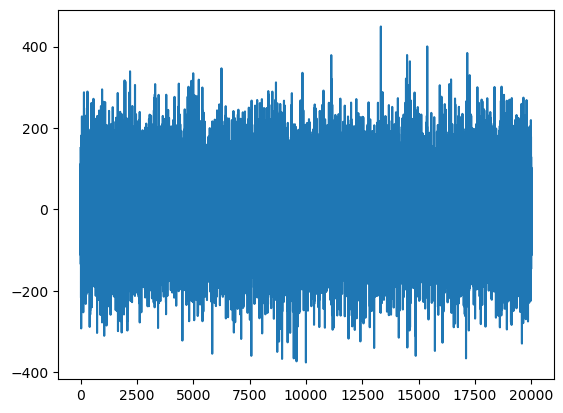

In [10]:
plt.plot(np.random.normal(0, 100, size=b.shape))

In [11]:
np.random.seed(42)
noisy_b = b + np.random.normal(0, 100, size=b.shape)
# Solve the least square problem
x_denoise = np.linalg.lstsq(A, b, rcond=None)[0]
x_noise = np.linalg.lstsq(A, noisy_b, rcond=None)[0]
with np.printoptions(precision=3, suppress=True):

    e1 = np.linalg.norm(x_denoise - all_base) / np.linalg.norm(all_base)
    e2 = np.linalg.norm(x_noise - all_base) / np.linalg.norm(all_base)
    print(all_base)
    print(x_denoise, e1)
    print(x_noise, e2)

[0.    0.3   1.09  1.    0.    0.163 1.026]
[-0.023  0.486  1.198  0.675  0.001  0.162  1.026] 0.21279553704060764
[ 0.109  0.626  1.343  0.804 -0.003  0.172  1.097] 0.2592929132361975


In [12]:
# try without first column - removed first parameter

A_smaller = np.delete(A, [0, 4], axis=1)
all_base_reduced = np.delete(all_base, [0, 4], axis=0)
x_noise_smaller = np.linalg.lstsq(A_smaller, noisy_b, rcond=None)[0]

with np.printoptions(precision=3, suppress=True):

    e3 = np.linalg.norm(x_noise_smaller - all_base_reduced) / np.linalg.norm(
        all_base_reduced
    )

    print(x_noise_smaller, e3)

[0.625 1.346 0.804 0.172 1.1  ] 0.2529130687769522


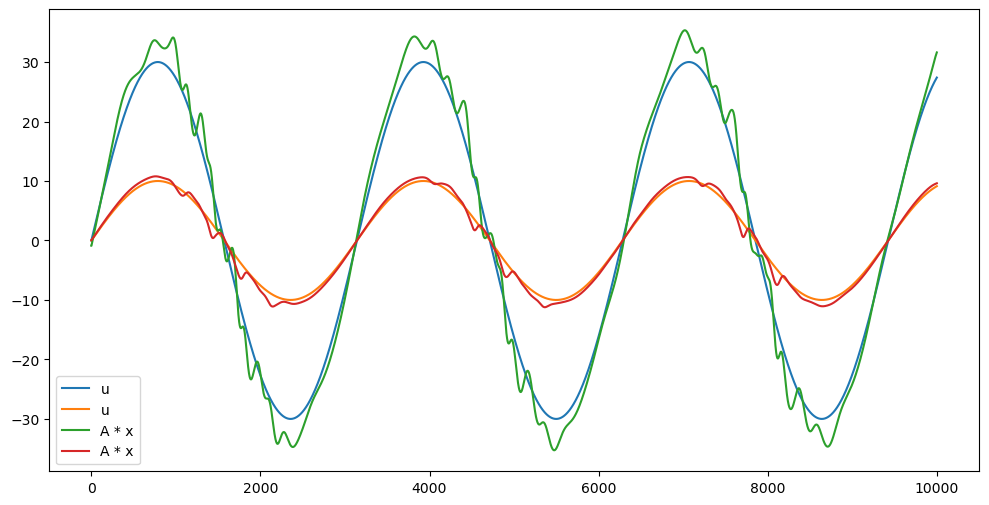

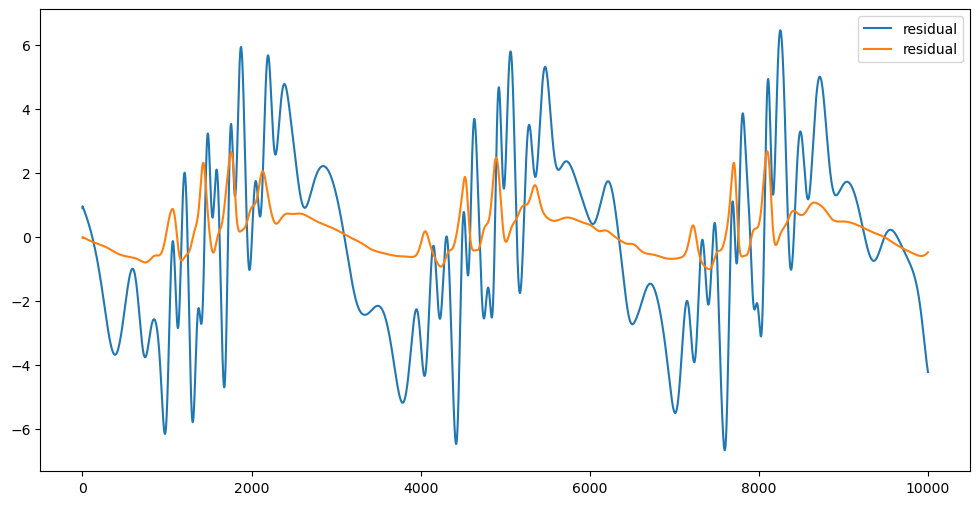

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(b.reshape(-1, model.nv), label="u")
plt.plot((A @ x_noise).reshape(-1, model.nv), label="A * x")
# plt.plot((A @ all_base).reshape(-1, model.nv), label="A * all_base")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(
    b.reshape(-1, model.nv) - (A @ x_noise).reshape(-1, model.nv), label="residual"
)
plt.legend()
plt.show()